In [1]:
data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data

N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)
#data <- read.table("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header = TRUE, sep = ",")
counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF,
                         data$dn.mis3, data$case.mis3+data$trans.mis3,
                         data$ctrl.mis3+data$ntrans.mis3))
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

y.case.lof <- counts[, 2]
y.control.lof <- counts[, 3]
y.case.mis3 <- counts[, 5]
y.control.mis3 <- counts[, 6]


## Use simulation functions from the TADA package

In [2]:
# Generate simulation data of a set of genes (multiple mutational categories): de novo mutations only
# N: sample size (number of trios)
# mu: mutation rate of each gene (a vector)
# mu.frac: for each type of mutation, its fraction of the gene's mutation rate
# pi: the fraction of risk genes 
# gamma.mean, beta: Relative risk of de novo mutation: gamma|M1 ~ Gamma(gamma.mean*beta, beta). Vectors (one per category) 
# Output: sample matrix (m by K), where m is the number of genes and K the number of variant categories. sample.info: more information of the samples, including the indicator (risk gene or not) and the RR. 

simulator.denovo <- function(N, mu, mu.frac, pi, gamma.mean, beta) {
  m <- length(mu) # number of genes
  K <- length(mu.frac) # number of mutational categories
  
  z <- rbinom(m, 1, pi)
  gamma <- array(1, dim=c(m,K))
  x <- array(0, dim=c(m,K))
  k <- sum(z==1)
  for (j in 1:K) {
    gamma[z==1, j] <- rgamma(k, gamma.mean[j]*beta[j], beta[j])
    x[,j] <- rpois(m, 2 * mu * mu.frac[j] * gamma[,j] * N)
  }
  
  sample.info <- cbind(mu, z, gamma, x)
  
  return (list(sample=x, sample.info=sample.info))
}

# Generate simulation data of a set of genes (multiple mutational categories)
# N: sample size (number of trios)
# mu: mutation rate of each gene (a vector)
# mu.frac: for each type of mutation, its fraction of the gene's mutation rate
# pi: the fraction of risk genes 
# gamma.mean.dn, beta.dn: Relative risk of de novo mutation: gamma|M1 ~ Gamma(gamma.mean.dn*beta.dn, beta.dn). Vectors.
# gamma.mean.CC, beta.CC: Relative risk of inherited mutation (case/control): gamma.CC|M1 ~ Gamma(gamma.mean.CC*beta.CC, beta.CC). Vectors
# Frequency parameter of risk genes: q|M1 ~ Gamma(rho1, nu1)
# Frequency parameter of non-risk genes: q|M0 ~ Gamma(rho0, nu0)
# tradeoff option: if TRUE, implement q-gamma tradeoff (i.e. higher gamma means lower q). Suppose, gamma_i is the RR, then q_i is proportional to mu_i / gamma_i, where the constant is determined from the mean of q, mu and gamma. 
# Output: sample matrix (m by 3K), where m is the number of genes and K the number of variant categories.  sample.info: more information of the samples, including the indicator (risk gene or not) and the RR.
simulator <- function(N, mu, mu.frac, pi, gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0, tradeoff=FALSE) {
  m <- length(mu) # number of genes
  K <- length(mu.frac) # number of mutational categories
  
  # the tradeoff parameter (delta:=mu.mean/q.mean)
  delta <- mean(mu) * mu.frac / (rho0 / nu0)
  
  z <- rbinom(m, 1, pi)
  gamma.dn <- array(1, dim=c(m,K))
  gamma.CC <- array(1, dim=c(m,K))
  q <- array(0, dim=c(m,K))
  x <- array(0, dim=c(m,3*K))
  k <- sum(z==1)
  for (j in 1:K) {
    # sample de novo 
    gamma.dn[z==1, j] <- rgamma(k, gamma.mean.dn[j]*beta.dn[j], beta.dn[j])
    col <- 3*(j-1)+1
    x[,col] <- rpois(m, 2 * mu * mu.frac[j] * gamma.dn[,j] * N$dn)
    
    # sample case-control
    gamma.CC[z==1, j] <- rgamma(k, gamma.mean.CC[j]*beta.CC[j], beta.CC[j])
    q[z==0, j] <- rgamma(m-k, rho0[j], nu0[j])
    if (tradeoff==FALSE) {
      q[z==1, j] <- rgamma(k, rho1[j], nu1[j])
    } else {
      q[z==1, j] <- mu[z==1] * mu.frac[j] / (delta[j] * gamma.CC[z==1, j])
    }
    x[,col+1] <- rpois(m, q[,j] * gamma.CC[,j] *N$ca)
    x[,col+2] <- rpois(m, q[,j] * N$cn)
    
  }
  
  sample.info <- cbind(mu, z, gamma.dn, gamma.CC, q, x)
  
  return (list(sample=x, sample.info=sample.info))
}



## Simulate for single category

### MCMC code using rstan

In [3]:
denovoBinomSingle <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;

int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];
}
parameters {
real<lower=0.0,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFdn;
//real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
hyperGammaMeanLoFdn ~ uniform(1, 70); //normal(15, 100);
//hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn, 1);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]);

ps[2] <- log(pi0)
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]*gammaLoFdn);

increment_log_prob(log_sum_exp(ps));
}

}
"


In [4]:
sDenovo <- simulator.denovo(N = N$dn, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.06, gamma.mean = 20, beta = 1)

class(sDenovo)
str(sDenovo)

sCountDenovo <- as.numeric(sDenovo[[1]])
table(sCountDenovo)


[1] "list"

List of 2
 $ sample     : num [1:18735, 1] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:4] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "mu" "z" "" ""


sCountDenovo
    0     1     2     3     5 
18425   283    21     5     1 

In [9]:
source("newTADA2016/TADA/TADA.v1.1.R")


mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo

C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 1

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
gamma.mean.dn=results$gamma.mean
M.expected=results$M
listGamma[k] <- gamma.mean.dn
listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])


In [10]:
outResult <- cbind(as.integer(listK), listGamma, listM, listK/length(yLoF), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")
outResult[order(outResult[, 5]), ]


nGene,GammaMean,M.expected,Risk_gene_proportion,Distance_M.ob_AND_es
200.00000000,121.37061468,48.74686610,0.01067521,261.25313390
1.000000e+02,2.417412e+02,4.735407e+01,5.337603e-03,2.626459e+02
7.500000e+01,3.219883e+02,4.382405e+01,4.003203e-03,2.661760e+02
500.00000000,49.14824587,37.84402184,0.02668802,272.15597816
5.000000e+01,4.824825e+02,3.680864e+01,2.668802e-03,2.731914e+02
562.00000,43.83271,35.95819,0.03000,274.04181
700.00000000,35.39160419,32.43960326,0.03736322,277.56039674
1.000000e+03,2.507412e+01,2.695017e+01,5.337603e-02,2.830498e+02
1.500000e+03,1.704942e+01,2.148788e+01,8.006405e-02,2.885121e+02
2000.0000000,13.0370615,18.2688240,0.1067521,291.7311760


In [11]:
source("newTADA2016/TADA/TADA.v1.1.R")


mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo

C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
gamma.mean.dn=results$gamma.mean
M.expected=results$M
listGamma[k] <- gamma.mean.dn
listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])


In [12]:
outResult <- cbind(as.integer(listK), listGamma, listM, listK/length(yLoF), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")
outResult[order(outResult[, 5]), ]


nGene,GammaMean,M.expected,Risk_gene_proportion,Distance_M.ob_AND_es
5.000000e+01,4.824825e+02,2.740822e+01,2.668802e-03,4.082168e-01
1.000000e+02,2.417412e+02,2.783345e+01,5.337603e-03,8.334523e-01
7.500000e+01,3.219883e+02,2.871915e+01,4.003203e-03,1.719155e+00
200.00000000,121.37061468,20.93827716,0.01067521,6.06172284
500.00000000,49.14824587,9.86346377,0.02668802,17.13653623
1.000000e+01,2.408412e+03,9.642562e+00,5.337603e-04,1.735744e+01
562.000000,43.832707,8.748011,0.030000,18.251989
700.00000000,35.39160419,6.91065495,0.03736322,20.08934505
1.000000e+03,2.507412e+01,4.609250e+00,5.337603e-02,2.239075e+01
1.500000e+03,1.704942e+01,2.866110e+00,8.006405e-02,2.413389e+01


In [13]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo
mixdataSingle <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      Ndn = N$dn, NN = length(yLoF))                 
library("rstan")
nSeed <- 233
mLoF <- stan_model(model_code = denovoBinomSingle)

fLoF <- vb(mLoF, seed = nSeed, data = mixdataSingle)

fLoF


Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.006222 seconds
1000 iterations under these settings should take 6.222 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -2e+03             1.000            1.000
   200    -1606.6             0.501            1.000
   300    -1607.0             0.334            0.003   MEDIAN ELBO CONVERGED

Drawing 1000

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: e7bbaacf0e818149de4ff9f10e60cad7.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd  2.5%   25%   50%   75% 97.5%
pi0                  0.06 0.01  0.04  0.05  0.06  0.07  0.08
hyperGammaMeanLoFdn 27.67 4.27 20.74 24.63 27.40 30.12 36.87
gammaLoFdn          24.52 2.24 20.26 22.98 24.46 25.98 29.12
lp__                 0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 16:28:19 2016.

In [14]:
nIteration = 10000
nThin = floor(nIteration/1000)

testFitSingle <- stan(model_code = denovoBinomSingle,
                      data = mixdataSingle, iter = nIteration, chains = 1, thin = nThin, 
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn'))


SAMPLING FOR MODEL 'e7bbaacf0e818149de4ff9f10e60cad7' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1, Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1, Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1, Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1, Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1, Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1, Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1, Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1, Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1, Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1, Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1, Iteration: 10000 / 10000 [100%]  (Sampling)# 
#  Elapsed Time: 207.384 seconds (Warm-up)
#                222.423 seconds (Sampling)
#                429.807 seconds (Total)
# 


Inference for Stan model: e7bbaacf0e818149de4ff9f10e60cad7.
1 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=500.

                        mean se_mean   sd     2.5%      25%      50%      75%
pi0                     0.06    0.00 0.01     0.04     0.05     0.05     0.06
hyperGammaMeanLoFdn    25.59    0.34 6.99    14.02    20.73    24.98    29.84
lp__                -1600.44    0.06 1.30 -1603.85 -1600.92 -1600.03 -1599.50
                       97.5% n_eff Rhat
pi0                     0.09   356 1.01
hyperGammaMeanLoFdn    40.48   435 1.01
lp__                -1599.00   482 1.00

Samples were drawn using NUTS(diag_e) at Tue Feb 23 16:35:32 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

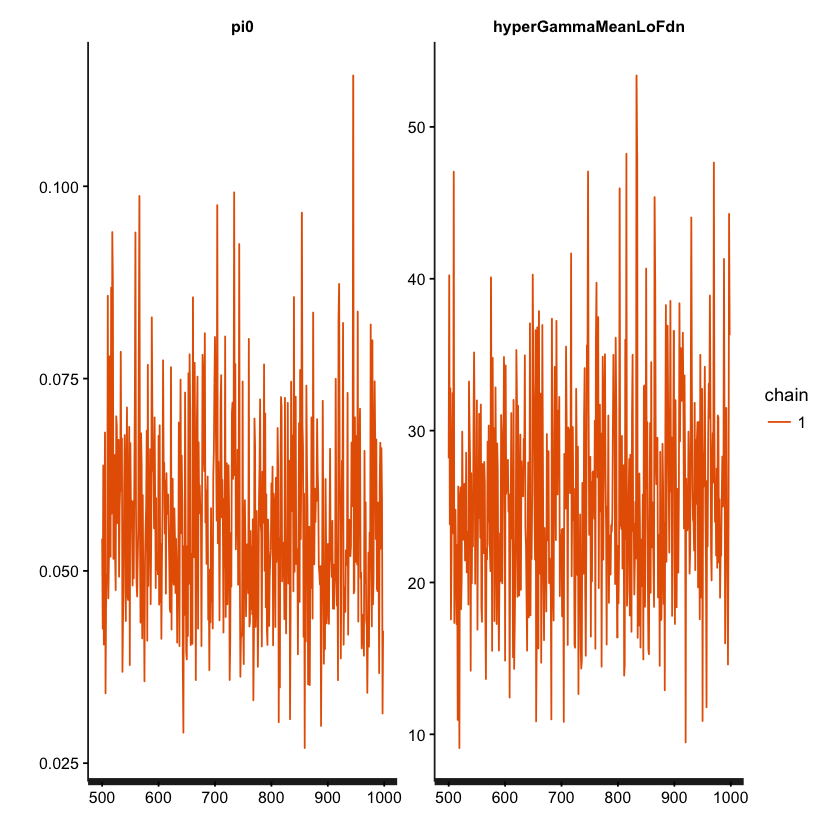

In [15]:
stan_trace(testFitSingle)
testFitSingle

## For multiple categories

In [16]:
sDenovo2 <- simulator.denovo(N = N$dn, mu = data$mut.rate, mu.frac = mu.frac, pi = 0.06, 
                             gamma.mean = c(20, 4.7), beta = c(1, 1))

class(sDenovo2)
str(sDenovo2)

sCountDenovo2 <- (sDenovo2$sample)
str(sCountDenovo2)
muSimu <- sDenovo[[2]][, 1]

[1] "list"

List of 2
 $ sample     : num [1:18735, 1:2] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:6] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:6] "mu" "z" "" "" ...
 num [1:18735, 1:2] 0 0 0 0 0 0 0 0 0 0 ...


In [17]:
denovoBinom2 <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;

int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];
}
parameters {
real<lower=0.0,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFdn;
//real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=1> hyperGammaMeanMis3dn;
//real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;



}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
hyperGammaMeanLoFdn ~ uniform(1, 70); //normal(15, 100);
//hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn, 1);

hyperGammaMeanMis3dn ~ uniform(1, 70); //normal(15, 100);
//hyperBetaLoFdn ~ normal(1, 0.01);
gammaMis3dn ~ gamma(hyperGammaMeanMis3dn, 1);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii]);

ps[2] <- log(pi0)
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn);
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]*gammaLoFdn) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii]*gammaMis3dn);

increment_log_prob(log_sum_exp(ps));
}

}
"


In [18]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountDenovo2[, 1]

mutMis3 <- data$mut.rate*mu.frac[2]
yMis3 <- sCountDenovo2[, 2]
mixdataSingle2 <- list(K = 2, 
                      yLoFdn = yLoF, mutLoF = mutLoF,
                      yMis3dn = yMis3, mutMis3 = mutMis3,
                      Ndn = N$dn, NN = length(yLoF))                 


In [19]:
library("rstan")
nSeed <- 233
mLoF2 <- stan_model(model_code = denovoBinom2)

fLoF2 <- vb(mLoF2, seed = nSeed, data = mixdataSingle2)

fLoF2

clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'

This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.010817 seconds
1000 iterations under these settings should take 10.817 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -4e+03             1.000            1.000
   200    -4236.0             0.501            1.000
   300    -4235.6             0.334            0.002   MEDIAN ELBO CONVERGED

Drawing 100

We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 0854f170d14d15dcb156f0a39a75feed.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                      mean   sd  2.5%   25%   50%   75% 97.5%
pi0                   0.04 0.01  0.03  0.04  0.04  0.05  0.05
hyperGammaMeanLoFdn  26.78 7.21 15.35 21.74 25.80 30.89 43.66
gammaLoFdn           23.64 1.74 20.47 22.44 23.61 24.75 27.20
hyperGammaMeanMis3dn  4.20 1.91  1.89  2.87  3.72  4.94  9.44
gammaMis3dn           3.25 0.62  2.30  2.80  3.17  3.59  4.73
lp__                  0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 16:36:55 2016.

In [22]:
nIteration = 10000
nThin = floor(nIteration/1000)

testFitSingle2 <- stan(model_code = denovoBinom2,
                      data = mixdataSingle2, iter = nIteration, chains = 1, thin = nThin, 
                      #control = list(adapt_delta = 0.9),
                      pars = c('pi0','hyperGammaMeanLoFdn', 'hyperGammaMeanMis3dn'))


SAMPLING FOR MODEL '0854f170d14d15dcb156f0a39a75feed' NOW (CHAIN 1).

Chain 1, Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1, Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1, Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1, Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1, Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1, Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1, Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1, Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1, Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1, Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1, Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1, Iteration: 10000 / 10000 [100%]  (Sampling)# 
#  Elapsed Time: 389.337 seconds (Warm-up)
#                459.99 seconds (Sampling)
#                849.326 seconds (Total)
# 


Inference for Stan model: 0854f170d14d15dcb156f0a39a75feed.
1 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=500.

                         mean se_mean   sd     2.5%      25%      50%      75%
pi0                      0.04    0.00 0.01     0.03     0.04     0.04     0.05
hyperGammaMeanLoFdn     25.58    0.31 6.91    13.56    20.86    25.00    29.86
hyperGammaMeanMis3dn     4.31    0.08 1.79     1.40     2.96     3.99     5.51
lp__                 -4226.32    0.08 1.66 -4230.26 -4227.17 -4226.00 -4225.10
                        97.5% n_eff Rhat
pi0                      0.06   500    1
hyperGammaMeanLoFdn     40.38   500    1
hyperGammaMeanMis3dn     8.06   500    1
lp__                 -4224.10   440    1

Samples were drawn using NUTS(diag_e) at Tue Feb 23 16:51:42 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, 

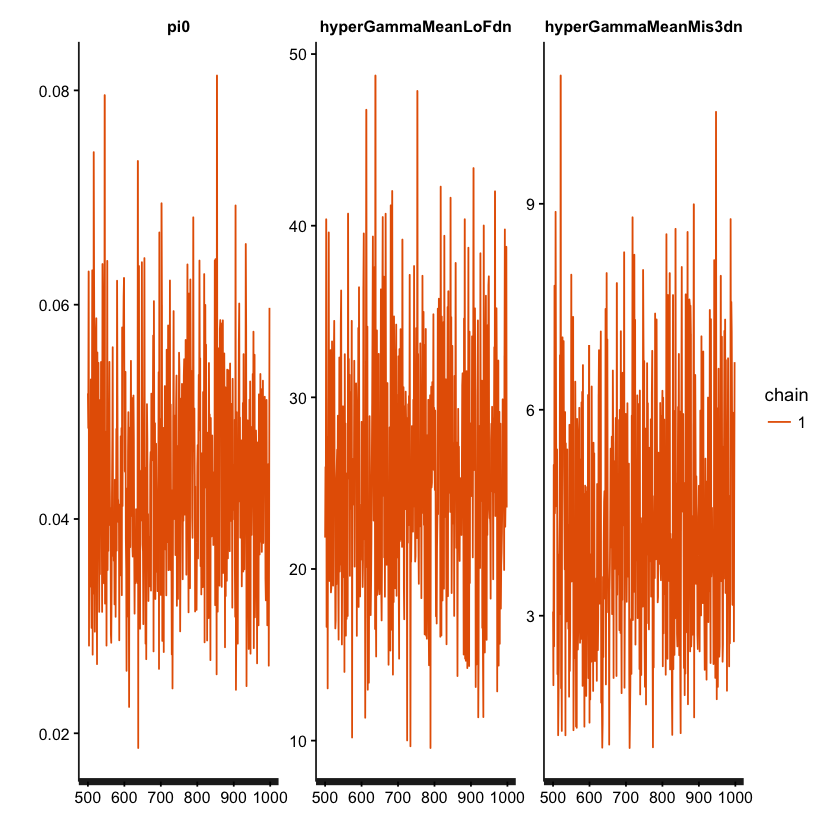

In [23]:
stan_trace(testFitSingle2)
testFitSingle2


In [30]:
source("newTADA2016/TADA/TADA.v1.1.R")
C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 2

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])
outResult <- cbind(round(listK, 0), round(listGamma, 2), round(listM, 2), 
                   round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")

outResult[order(outResult[, 5]), ]

nGene,GammaMean,M.expected,Risk_gene_proportion,Distance_M.ob_AND_es
50.000000,363.360000,21.560000,0.003000,3.442845
75.000000,242.570000,20.970000,0.004000,4.034708
100.000000,182.180000,19.290000,0.005000,5.709464
200.0000,91.5900,12.9900,0.0110,12.0056
10.00000,1812.81000,9.34000,0.00100,15.65526
500.00000,37.24000,5.51000,0.02700,19.48906
562.00000,33.24000,4.85000,0.03000,20.15488
700.00000,26.88000,3.77000,0.03700,21.22658
1000.00000,19.12000,2.48000,0.05300,22.52267
1500.00000,13.08000,1.54000,0.08000,23.45834


In [31]:
source("newTADA2016/TADA/TADA.v1.1.R")
C=sum(yLoF)
listGamma <- NULL
listM <- NULL
d0 = 1

listK <- c(10, 50, 75, 100, 200, 500, 0.03*length(yLoF), 700, 1000, 1500, 2000, 2500, 3000)
for (k in 1:length(listK)){
  results=denovo.MOM(k= listK[k], N=N$dn, mu= mutLoF, C=C, beta=1, d= d0)
  gamma.mean.dn=results$gamma.mean
  M.expected=results$M
  listGamma[k] <- gamma.mean.dn
  listM[k] <- M.expected
}

M.observed <- length(yLoF[yLoF>= d0])
outResult <- cbind(round(listK), round(listGamma, 2), round(listM, 2), 
                   round(listK/length(yLoF), 3), abs(listM - M.observed))
colnames(outResult) <- c("nGene", "GammaMean", "M.expected", "Risk_gene_proportion", "Distance_M.ob_AND_es")

outResult[order(outResult[, 5]), ]

nGene,GammaMean,M.expected,Risk_gene_proportion,Distance_M.ob_AND_es
100.0000,182.1800,37.3200,0.0050,230.6798
75.0000,242.5700,35.9000,0.0040,232.0969
200.000,91.590,35.270,0.011,232.729
50.0000,363.3600,31.8400,0.0030,236.1557
500.000,37.240,25.360,0.027,242.645
562.00,33.24,23.94,0.03,244.06
700.000,26.880,21.400,0.037,246.600
1000.000,19.120,17.630,0.053,250.373
1500.0000,13.0800,14.0600,0.0800,253.9353
2000.0000,10.0600,12.0300,0.1070,255.9703


## Simulate for case-control AND de novo data

In [33]:
sDenovoCC <- simulator(N = N, mu = data$mut.rate, mu.frac = mu.frac[1], pi = 0.15, 
                             gamma.mean.dn = 20, beta.dn = 1,
                       gamma.mean.CC = 2.3, beta.CC = 4, 
                       rho1 = rho0[1], nu1 = nu0[1],
                       rho0 = rho0[1], nu0 = nu0[1])

class(sDenovoCC)
str(sDenovoCC)

sCountCC <- (sDenovoCC$sample)
str(sCountCC)

head(sCountCC)


[1] "list"

List of 2
 $ sample     : num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...
 $ sample.info: num [1:18735, 1:8] 2.35e-05 2.17e-05 6.09e-06 5.64e-05 5.70e-05 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:8] "mu" "z" "" "" ...
 num [1:18735, 1:3] 0 0 0 0 0 0 0 0 0 0 ...


0,0,0
0,2,0
0,0,0
0,0,0
0,0,2
0,0,0


In [34]:
denovoCCBinom <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];


real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;
real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;


}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
hyperGammaMeanLoFdn ~ normal(15, 10);
hyperBetaLoFdn ~ normal(1, 0.01);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);


for (ii in 1:NN){
ps[1] <- log1m(pi0) 
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0);

ps[2] <- log(pi0)
+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"


In [35]:
mutLoF <- data$mut.rate*mu.frac[1] #muSimu
yLoF <-  sCountCC[, 1]
y.case.lof <- sCountCC[, 2]
y.control.lof <- sCountCC[, 3]

#y.case.lof <- y.case.lof + y.case.mis3; y.control.lof <- y.control.lof + y.control.mis3; mutLoF <- mutLoF + mutMis3
mixdataDenovoCC <- list(K = 2, 
                        yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                        yLoFdn = yLoF, mutLoF = mutLoF,
                        NN = length(y.case.lof),
                        Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                        Ndn = N$dn,
                        thetaH0 = N$ca/(N$ca + N$cn))


In [40]:
NSample <- 50000
mBothDenovoCC <- stan_model(model_code = denovoCCBinom)

nSeed1 <- floor(runif(1, 1, 10^6)) #233
fBothDenovoCC <- vb(mBothDenovoCC, seed = nSeed1,
                    data = mixdataDenovoCC,
                    iter = NSample, output_samples= 1000)



This is Automatic Differentiation Variational Inference.

(EXPERIMENTAL ALGORITHM: expect frequent updates to the procedure.)

Gradient evaluation took 0.0182 seconds
1000 iterations under these settings should take 18.2 seconds.
Adjust your expectations accordingly!

Begin eta adaptation.
Iteration:   1 / 250 [  0%]  (Adaptation)
Iteration:  50 / 250 [ 20%]  (Adaptation)
Iteration: 100 / 250 [ 40%]  (Adaptation)
Iteration: 150 / 250 [ 60%]  (Adaptation)
Iteration: 200 / 250 [ 80%]  (Adaptation)
Success! Found best value [eta = 1] earlier than expected.

Begin stochastic gradient ascent.
  iter       ELBO   delta_ELBO_mean   delta_ELBO_med   notes 
   100     -1e+04             1.000            1.000
   200   -13451.8             0.504            1.000
   300   -13313.6             0.339            0.010
   400   -13327.6             0.255            0.010
   500   -13306.4             0.204            0.008   MEDIAN ELBO CONVERGED

Drawing 1000 samples from the approximate posterior.

In [41]:
fBothDenovoCC


We recommend genuine 'sampling' from the posterior distribution for final inferences!
We recommend genuine 'sampling' from the posterior distribution for final inferences!


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

                     mean   sd  2.5%   25%   50%   75% 97.5%
pi0                  0.13 0.01  0.12  0.13  0.13  0.14  0.14
hyperGammaMeanLoFcc  3.18 0.95  1.86  2.51  2.98  3.68  5.47
hyperBetaLoFcc       4.07 0.01  4.06  4.07  4.07  4.08  4.09
gammaLoFcc           2.72 0.08  2.57  2.66  2.71  2.77  2.87
hyperGammaMeanLoFdn 20.87 3.27 15.11 18.62 20.68 22.87 27.81
hyperBetaLoFdn       1.01 0.01  0.99  1.00  1.01  1.01  1.03
gammaLoFdn          22.19 1.10 20.17 21.43 22.17 22.90 24.30
lp__                 0.00 0.00  0.00  0.00  0.00  0.00  0.00

Approximate samples were drawn using VB(meanfield) at Tue Feb 23 17:26:12 2016.

In [38]:
nIteration = 3000
nThin = floor(nIteration/1000)
testFitDenovoCC <- stan(model_code = denovoCCBinom,
                        data = mixdataDenovoCC, iter = nIteration, 
                        chains = 2, cores = 2, thin = nThin,
#                        control = list(adapt_delta = 0.9),
                        pars = c('pi0',
                                 'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                 'hyperBetaLoFdn', 'hyperBetaLoFcc'))


Inference for Stan model: 164d5a370c0efe99cd0014a985c9baee.
2 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=5000.

                         mean se_mean   sd      2.5%       25%       50%
pi0                      0.13    0.00 0.01      0.12      0.13      0.13
hyperGammaMeanLoFdn     22.32    0.08 4.25     14.49     19.41     22.06
hyperGammaMeanLoFcc      3.05    0.02 0.82      1.54      2.48      3.00
hyperBetaLoFdn           1.00    0.00 0.01      0.98      0.99      1.00
hyperBetaLoFcc           4.00    0.00 0.01      3.98      3.99      4.00
lp__                -13267.33    0.04 1.94 -13272.05 -13268.43 -13266.96
                          75%     97.5% n_eff Rhat
pi0                      0.14      0.15  2895    1
hyperGammaMeanLoFdn     25.16     30.93  3212    1
hyperGammaMeanLoFcc      3.57      4.79  2714    1
hyperBetaLoFdn           1.01      1.02  4039    1
hyperBetaLoFcc           4.01      4.02  4456    1
lp__ 

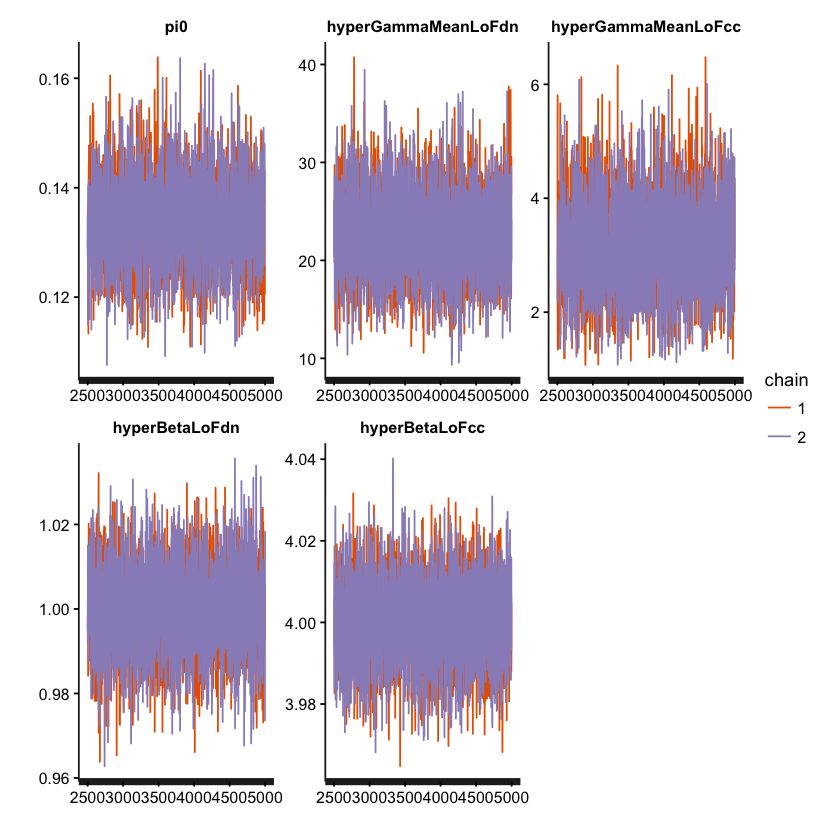

In [39]:
testFitDenovoCC
stan_trace(testFitDenovoCC)